In [26]:
import os
import warnings
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [27]:
df_temp = pd.read_csv('Data/Earth Surface Temperature Data/GlobalLandTemperaturesByCity.csv')
df_co2 = pd.read_csv('Data/annual-co2-emissions-per-country.csv')

In [28]:
def trim_data(city, country):
    # Filter temperature data for the selected city
    city_data = df_temp[df_temp['City'] == city].copy()
    city_data['dt'] = pd.to_datetime(city_data['dt'])
    city_data.set_index('dt', inplace=True)
    city_data = city_data.sort_values('dt')

    # Filter CO2 data for the selected country
    state_data = df_co2[df_co2['Entity'] == country].copy()
    state_data['Year'] = pd.to_datetime(state_data['Year'], format='%Y')
    state_data.set_index('Year', inplace=True)
    state_data = state_data.sort_values('Year')

    # Calculate overlapping date range
    start_date = max(city_data.index.min(), state_data.index.min())
    end_date = min(city_data.index.max(), state_data.index.max())

    # Check if there is a valid overlapping range
    if start_date >= end_date:
        print(f"No overlapping data for {city} in {country}.")

    # Trim both datasets to the overlapping date range
    city_data = city_data[start_date:end_date]
    state_data = state_data[start_date:end_date]

    # Interpolate both datasets to monthly frequency
    monthly_temp = city_data.resample('MS').interpolate('linear')
    monthly_co2 = state_data.resample('MS').interpolate('linear')

    print(f"Temperaturedate range for {city}: {monthly_temp.index.min()} to {monthly_temp.index.max()}")
    print(f"CO2 date range for {country}: {monthly_co2.index.min()} to {monthly_co2.index.max()}")

    # Merge the interpolated datasets
    combined_data = pd.merge(monthly_temp, monthly_co2, how='left', left_index=True, right_index=True)
    combined_data.fillna(method='bfill')
    combined_data.fillna(method='ffill', inplace=True)

    # Find the first and last non-NaN index for AverageTemperature
    first_valid_index = combined_data['AverageTemperature'].first_valid_index()
    last_valid_index = combined_data['AverageTemperature'].last_valid_index()

    # Trim the DataFrame
    trimmed_data = combined_data.loc[first_valid_index:last_valid_index]

    if not city_data['AverageTemperature'].dropna().empty:
        print("Non-null temperature entries exist, backfilling might work with proper alignment.")
    else:
        print("No non-null temperature entries found, backfilling cannot work.")

    nan_count_average_temp = trimmed_data['AverageTemperature'].isna().sum()
    nan_count_average_temp_uncertainty = trimmed_data['AverageTemperatureUncertainty'].isna().sum()

    print("Number of NaN values in 'AverageTemperature':", nan_count_average_temp)
    print("Number of NaN values in 'AverageTemperatureUncertainty':", nan_count_average_temp_uncertainty)

    return trimmed_data

In [29]:
def split_data(data, test_size=0.2):
    split_point = int(len(data) * (1 - test_size))
    train_data = data[:split_point]
    test_data = data[split_point:]
    return train_data, test_data

def preprocess_data(data, look_back=1, scaler=None):

    print(data.head())

    # Resample to monthly average
    data = data[['AverageTemperature', 'AverageTemperatureUncertainty', 'Annual CO₂ emissions']]

    # Check if scaler is provided
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
    else:
        scaled_data = scaler.transform(data)

    # Create dataset matrix
    dataX, dataY = [], []
    for i in range(len(scaled_data) - look_back):
        a = scaled_data[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(scaled_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY), scaler

# Create LSTM
def create_lstm_model(X_train, Y_train, X_val, Y_val, look_back=12, epochs=50, batch_size=32):
    
    # Determine the number of features
    num_features = X_train.shape[2]

    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, num_features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Fit the model
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), verbose=2)

    return model, history

In [30]:
# Delete Existing models to re-run code
dir_path = './Models/CO2_Temp/RandomCities'

# Check if the directory exists
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
    print(f"Directory '{dir_path}' has been deleted.")
else:
    print(f"Directory '{dir_path}' does not exist.")

Directory './Models/CO2_Temp/RandomCities' has been deleted.


In [31]:
city_to_country = {
    'Jiddah': 'Saudi Arabia',
    'Acapulco': 'Mexico',
    'Edmonton': 'Canada',
    'Irkutsk': 'Russia',
    'Bac Lieu': 'Vietnam'
}
look_back = 60

if not os.path.exists('./Models/CO2_Temp/RandomCities'):
    os.makedirs('./Models/CO2_Temp/RandomCities')

models = {}
histories = {}

# Create models for each city
for city, country in city_to_country.items():
    print(f"Processing data for {city} in {country}")
    
    data = trim_data(city, country)
    train_data, test_data = split_data(data)

    # Preprocess the data
    dataX, dataY, scaler = preprocess_data(train_data, look_back)
    print(f"Data shapes for {city}: Inputs - {dataX.shape}, Outputs - {dataY.shape}")

    # Split data into training and validation
    X_train, X_val, Y_train, Y_val = train_test_split(dataX, dataY, test_size=0.2, random_state=42)

    # Create and train the LSTM model
    model, history = create_lstm_model(X_train, Y_train, X_val, Y_val, look_back)
    models[city] = (model, scaler, test_data, look_back)
    histories[city] = history

    # Save the model
    model_path = f'./Models/CO2_Temp/RandomCities/{city}_model.h5'
    model.save(model_path)
    print(f"Model for {city} saved at {model_path}.")



Processing data for Jiddah in Saudi Arabia
Temperature data date range for Jiddah: 1936-01-01 00:00:00 to 2013-09-01 00:00:00
CO2 data date range for Saudi Arabia: 1936-01-01 00:00:00 to 2013-01-01 00:00:00
Non-null temperature entries exist, backfilling might work with proper alignment.
Number of NaN values in 'AverageTemperature': 0
Number of NaN values in 'AverageTemperatureUncertainty': 0
            AverageTemperature  AverageTemperatureUncertainty    City  \
dt                                                                      
1936-01-01              23.041                          0.993  Jiddah   
1936-02-01              23.865                          0.686  Jiddah   
1936-03-01              25.612                          0.979  Jiddah   
1936-04-01              27.239                          1.123  Jiddah   
1936-05-01              29.106                          0.906  Jiddah   

                 Country Latitude Longitude        Entity Code  \
dt                        

2024-05-01 19:27:50.230575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:27:50.232874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:27:50.234323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 - 11s - loss: 0.1549 - val_loss: 0.0903 - 11s/epoch - 634ms/step
Epoch 2/50
18/18 - 7s - loss: 0.0673 - val_loss: 0.0720 - 7s/epoch - 375ms/step
Epoch 3/50
18/18 - 7s - loss: 0.0582 - val_loss: 0.0646 - 7s/epoch - 407ms/step
Epoch 4/50
18/18 - 8s - loss: 0.0545 - val_loss: 0.0615 - 8s/epoch - 431ms/step
Epoch 5/50
18/18 - 8s - loss: 0.0520 - val_loss: 0.0605 - 8s/epoch - 459ms/step
Epoch 6/50
18/18 - 9s - loss: 0.0504 - val_loss: 0.0571 - 9s/epoch - 487ms/step
Epoch 7/50
18/18 - 7s - loss: 0.0496 - val_loss: 0.0545 - 7s/epoch - 379ms/step
Epoch 8/50
18/18 - 4s - loss: 0.0460 - val_loss: 0.0513 - 4s/epoch - 224ms/step
Epoch 9/50
18/18 - 9s - loss: 0.0427 - val_loss: 0.0486 - 9s/epoch - 474ms/step
Epoch 10/50
18/18 - 11s - loss: 0.0393 - val_loss: 0.0436 - 11s/epoch - 609ms/step
Epoch 11/50
18/18 - 7s - loss: 0.0346 - val_loss: 0.0381 - 7s/epoch - 416ms/step
Epoch 12/50
18/18 - 6s - loss: 0.0275 - val_loss: 0.0278 - 6s/epoch - 309ms/step
Epoch 13/50
18/18 - 9s - loss: 0.0166 - val_

2024-05-01 19:34:15.662519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:34:15.664473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:34:15.665881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 - 15s - loss: 0.1349 - val_loss: 0.0374 - 15s/epoch - 548ms/step
Epoch 2/50
28/28 - 10s - loss: 0.0413 - val_loss: 0.0324 - 10s/epoch - 370ms/step
Epoch 3/50
28/28 - 11s - loss: 0.0389 - val_loss: 0.0314 - 11s/epoch - 410ms/step
Epoch 4/50
28/28 - 9s - loss: 0.0377 - val_loss: 0.0302 - 9s/epoch - 333ms/step
Epoch 5/50
28/28 - 9s - loss: 0.0367 - val_loss: 0.0295 - 9s/epoch - 328ms/step
Epoch 6/50
28/28 - 7s - loss: 0.0355 - val_loss: 0.0278 - 7s/epoch - 264ms/step
Epoch 7/50
28/28 - 11s - loss: 0.0338 - val_loss: 0.0280 - 11s/epoch - 408ms/step
Epoch 8/50
28/28 - 11s - loss: 0.0323 - val_loss: 0.0250 - 11s/epoch - 376ms/step
Epoch 9/50
28/28 - 11s - loss: 0.0307 - val_loss: 0.0238 - 11s/epoch - 410ms/step
Epoch 10/50
28/28 - 9s - loss: 0.0267 - val_loss: 0.0215 - 9s/epoch - 339ms/step
Epoch 11/50
28/28 - 7s - loss: 0.0222 - val_loss: 0.0129 - 7s/epoch - 264ms/step
Epoch 12/50
28/28 - 9s - loss: 0.0124 - val_loss: 0.0117 - 9s/epoch - 337ms/step
Epoch 13/50
28/28 - 10s - loss: 0.01

2024-05-01 19:41:41.211083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:41:41.213369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:41:41.215008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

51/51 - 21s - loss: 0.1115 - val_loss: 0.0565 - 21s/epoch - 415ms/step
Epoch 2/50
51/51 - 16s - loss: 0.0537 - val_loss: 0.0487 - 16s/epoch - 317ms/step
Epoch 3/50
51/51 - 20s - loss: 0.0427 - val_loss: 0.0321 - 20s/epoch - 390ms/step
Epoch 4/50
51/51 - 15s - loss: 0.0194 - val_loss: 0.0069 - 15s/epoch - 290ms/step
Epoch 5/50
51/51 - 14s - loss: 0.0068 - val_loss: 0.0058 - 14s/epoch - 271ms/step
Epoch 6/50
51/51 - 14s - loss: 0.0059 - val_loss: 0.0085 - 14s/epoch - 283ms/step
Epoch 7/50
51/51 - 14s - loss: 0.0057 - val_loss: 0.0069 - 14s/epoch - 266ms/step
Epoch 8/50
51/51 - 14s - loss: 0.0052 - val_loss: 0.0045 - 14s/epoch - 280ms/step
Epoch 9/50
51/51 - 14s - loss: 0.0048 - val_loss: 0.0044 - 14s/epoch - 275ms/step
Epoch 10/50
51/51 - 16s - loss: 0.0046 - val_loss: 0.0056 - 16s/epoch - 313ms/step
Epoch 11/50
51/51 - 11s - loss: 0.0045 - val_loss: 0.0040 - 11s/epoch - 220ms/step
Epoch 12/50
51/51 - 15s - loss: 0.0043 - val_loss: 0.0041 - 15s/epoch - 290ms/step
Epoch 13/50
51/51 - 17s 

2024-05-01 19:55:06.639348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 19:55:06.641208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 19:55:06.642571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 - 16s - loss: 0.1085 - val_loss: 0.0732 - 16s/epoch - 383ms/step
Epoch 2/50
43/43 - 14s - loss: 0.0705 - val_loss: 0.0635 - 14s/epoch - 333ms/step
Epoch 3/50
43/43 - 18s - loss: 0.0583 - val_loss: 0.0448 - 18s/epoch - 427ms/step
Epoch 4/50
43/43 - 14s - loss: 0.0229 - val_loss: 0.0046 - 14s/epoch - 329ms/step
Epoch 5/50
43/43 - 13s - loss: 0.0032 - val_loss: 0.0022 - 13s/epoch - 309ms/step
Epoch 6/50
43/43 - 15s - loss: 0.0027 - val_loss: 0.0023 - 15s/epoch - 359ms/step
Epoch 7/50
43/43 - 13s - loss: 0.0025 - val_loss: 0.0028 - 13s/epoch - 304ms/step
Epoch 8/50
43/43 - 8s - loss: 0.0027 - val_loss: 0.0019 - 8s/epoch - 187ms/step
Epoch 9/50
43/43 - 10s - loss: 0.0024 - val_loss: 0.0024 - 10s/epoch - 229ms/step
Epoch 10/50
43/43 - 11s - loss: 0.0024 - val_loss: 0.0024 - 11s/epoch - 249ms/step
Epoch 11/50
43/43 - 13s - loss: 0.0024 - val_loss: 0.0021 - 13s/epoch - 291ms/step
Epoch 12/50
43/43 - 10s - loss: 0.0023 - val_loss: 0.0023 - 10s/epoch - 234ms/step
Epoch 13/50
43/43 - 10s - 

2024-05-01 20:04:31.905838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 20:04:31.907894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 20:04:31.909286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 - 15s - loss: 0.0897 - val_loss: 0.0398 - 15s/epoch - 529ms/step
Epoch 2/50
28/28 - 7s - loss: 0.0311 - val_loss: 0.0319 - 7s/epoch - 243ms/step
Epoch 3/50
28/28 - 6s - loss: 0.0289 - val_loss: 0.0301 - 6s/epoch - 215ms/step
Epoch 4/50
28/28 - 4s - loss: 0.0272 - val_loss: 0.0277 - 4s/epoch - 161ms/step
Epoch 5/50
28/28 - 4s - loss: 0.0254 - val_loss: 0.0247 - 4s/epoch - 128ms/step
Epoch 6/50
28/28 - 3s - loss: 0.0214 - val_loss: 0.0204 - 3s/epoch - 117ms/step
Epoch 7/50
28/28 - 4s - loss: 0.0152 - val_loss: 0.0110 - 4s/epoch - 161ms/step
Epoch 8/50
28/28 - 5s - loss: 0.0078 - val_loss: 0.0089 - 5s/epoch - 196ms/step
Epoch 9/50
28/28 - 6s - loss: 0.0069 - val_loss: 0.0078 - 6s/epoch - 217ms/step
Epoch 10/50
28/28 - 3s - loss: 0.0064 - val_loss: 0.0074 - 3s/epoch - 115ms/step
Epoch 11/50
28/28 - 6s - loss: 0.0062 - val_loss: 0.0070 - 6s/epoch - 232ms/step
Epoch 12/50
28/28 - 6s - loss: 0.0057 - val_loss: 0.0067 - 6s/epoch - 197ms/step
Epoch 13/50
28/28 - 5s - loss: 0.0056 - val_lo

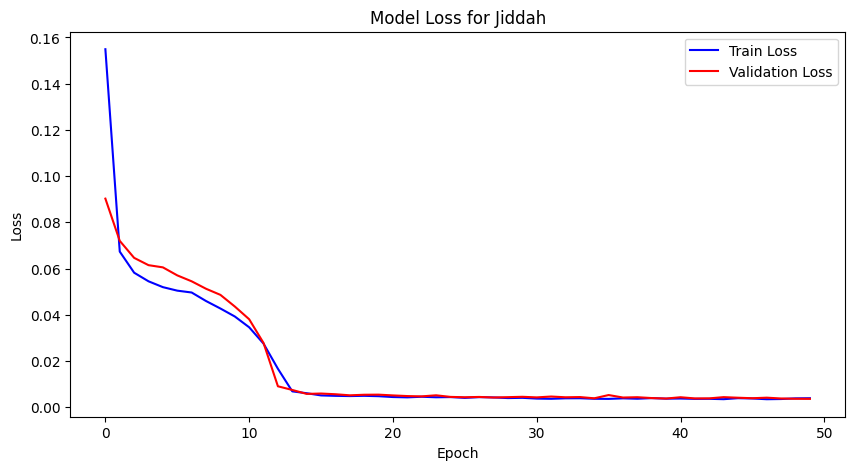

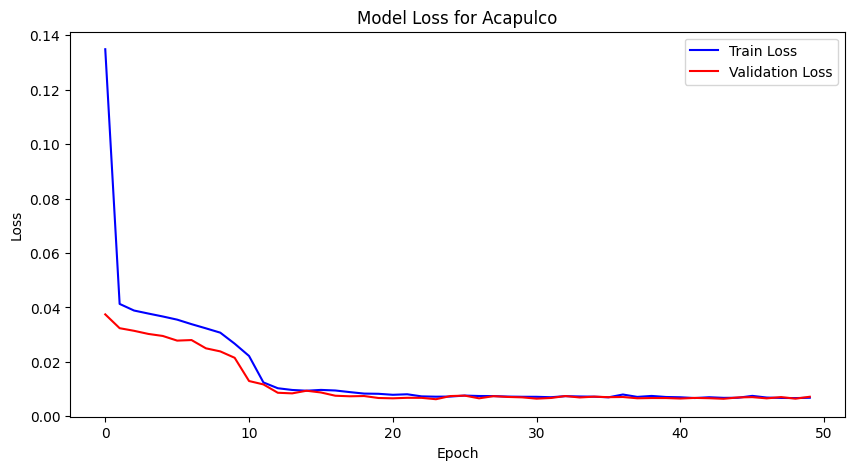

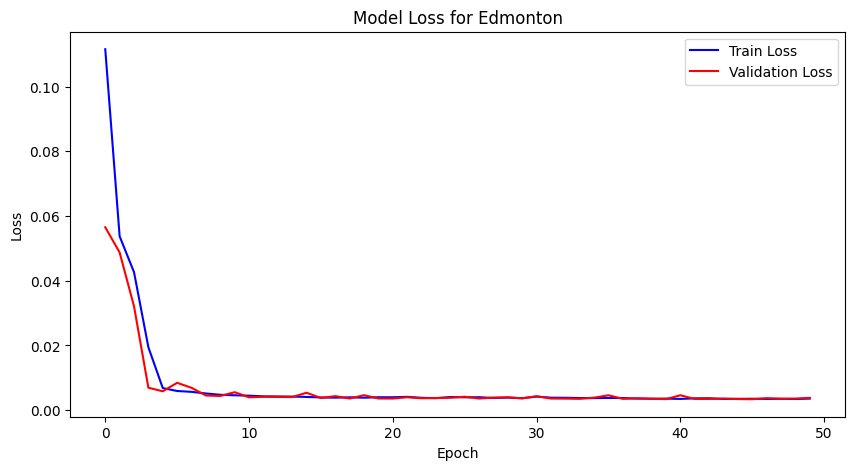

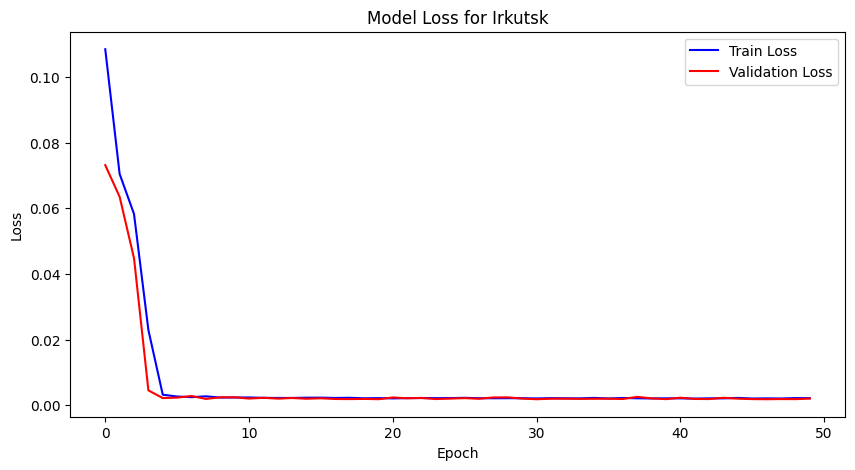

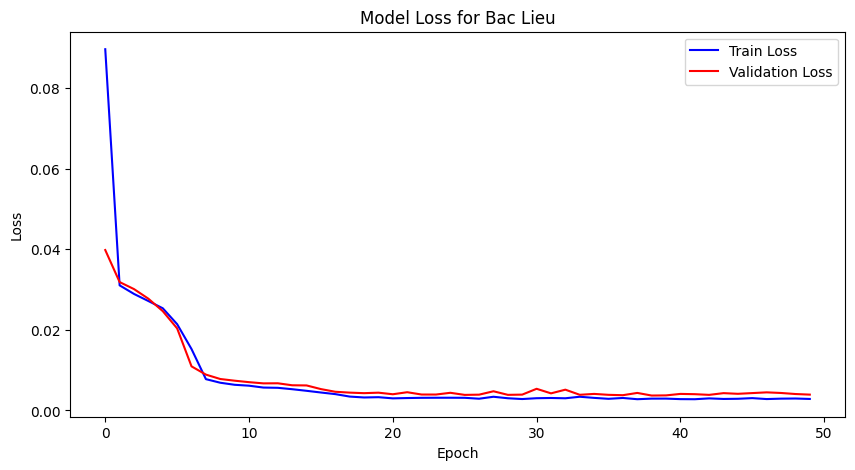

In [32]:
for city, history in histories.items():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(f'Model Loss for {city}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
loaded_models = {}
for city, model_info in models.items():
    _, scaler, test_data, look_back = model_info
    
    model = load_model(f'./Models/CO2_Temp/RandomCities/{city}_model.h5')
    loaded_models[city] = (model, scaler, test_data, look_back)
    print(f"Model for {city} loaded.")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from math import sqrt

def evaluate_model(city, model_info):
    print(model_info)
    model, scaler, test_data, look_back = model_info

    testX, testY, _ = preprocess_data(test_data, look_back=look_back, scaler=scaler)

    # Make predictions
    predictions = model.predict(testX)

    # Calculate metrics
    mse = mean_squared_error(testY, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(testY, predictions)
    r2 = r2_score(testY, predictions)
    explained_variance = explained_variance_score(testY, predictions)

    return {
        'City': city,
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R-squared': r2,
        'Explained Variance': explained_variance
    }

print(loaded_models)

results = []
for city, model_info in loaded_models.items():
    result = evaluate_model(city, model_info)
    results.append(result)

results_df = pd.DataFrame(results)
print(len(results_df))
results_df

{'Jiddah': (<keras.engine.sequential.Sequential object at 0x7fe659cbe150>, MinMaxScaler(),             AverageTemperature  AverageTemperatureUncertainty    City  \
dt                                                                      
1998-03-01              23.649                          0.339  Jiddah   
1998-04-01              27.812                          0.328  Jiddah   
1998-05-01              29.900                          0.295  Jiddah   
1998-06-01              31.018                          0.275  Jiddah   
1998-07-01              33.102                          0.449  Jiddah   
...                        ...                            ...     ...   
2013-05-01              30.222                          0.541  Jiddah   
2013-06-01              31.623                          0.740  Jiddah   
2013-07-01              33.238                          1.001  Jiddah   
2013-08-01              32.800                          1.425  Jiddah   
2013-09-01              32.800   

2024-05-01 20:09:58.538907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 20:09:58.541083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 20:09:58.542789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 223ms/step
(<keras.engine.sequential.Sequential object at 0x7fe75eadc4d0>, MinMaxScaler(),             AverageTemperature  AverageTemperatureUncertainty      City  \
dt                                                                        
1989-03-01              23.710                          0.609  Acapulco   
1989-04-01              24.148                          1.327  Acapulco   
1989-05-01              26.656                          0.404  Acapulco   
1989-06-01              27.504                          0.460  Acapulco   
1989-07-01              27.802                          0.331  Acapulco   
...                        ...                            ...       ...   
2013-05-01              26.628                          0.929  Acapulco   
2013-06-01              28.092                          0.394  Acapulco   
2013-07-01              27.885                          0.383  Acapulco   
2013-08-01              27.725            

2024-05-01 20:10:00.322979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 20:10:00.325171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 20:10:00.326912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 2s 186ms/step
(<keras.engine.sequential.Sequential object at 0x7fe75e997610>, MinMaxScaler(),             AverageTemperature  AverageTemperatureUncertainty      City  \
dt                                                                        
1970-04-01               3.072                          0.316  Edmonton   
1970-05-01              10.366                          0.207  Edmonton   
1970-06-01              16.891                          0.512  Edmonton   
1970-07-01              16.582                          0.249  Edmonton   
1970-08-01              15.744                          0.314  Edmonton   
...                        ...                            ...       ...   
2013-05-01              12.902                          0.376  Edmonton   
2013-06-01              14.412                          0.398  Edmonton   
2013-07-01              15.547                          0.300  Edmonton   
2013-08-01              16.713            

2024-05-01 20:10:03.379767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 20:10:03.381980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 20:10:03.383728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 3s 135ms/step
(<keras.engine.sequential.Sequential object at 0x7fe75e84ee50>, MinMaxScaler(),             AverageTemperature  AverageTemperatureUncertainty     City  \
dt                                                                       
1977-01-01             -25.088                          0.185  Irkutsk   
1977-02-01             -20.764                          0.364  Irkutsk   
1977-03-01              -8.989                          0.354  Irkutsk   
1977-04-01              -0.940                          0.451  Irkutsk   
1977-05-01               5.233                          0.400  Irkutsk   
...                        ...                            ...      ...   
2013-05-01               7.022                          1.003  Irkutsk   
2013-06-01              12.116                          0.437  Irkutsk   
2013-07-01              15.227                          0.498  Irkutsk   
2013-08-01              15.434                     

2024-05-01 20:10:06.168872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 20:10:06.170902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 20:10:06.172577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 2s 149ms/step
(<keras.engine.sequential.Sequential object at 0x7fe75ea9a950>, MinMaxScaler(),             AverageTemperature  AverageTemperatureUncertainty      City  \
dt                                                                        
1989-05-01              28.395                          0.472  Bac Lieu   
1989-06-01              28.445                          0.357  Bac Lieu   
1989-07-01              28.419                          0.301  Bac Lieu   
1989-08-01              28.008                          0.441  Bac Lieu   
1989-09-01              27.832                          0.253  Bac Lieu   
...                        ...                            ...       ...   
2013-05-01              29.404                          0.302  Bac Lieu   
2013-06-01              29.021                          0.320  Bac Lieu   
2013-07-01              28.443                          0.588  Bac Lieu   
2013-08-01              28.385          

2024-05-01 20:10:09.210293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 20:10:09.212474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 20:10:09.214233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 86ms/step
5


,City,RMSE,MSE,MAE,R-squared,Explained Variance
0,Jiddah,0.054247,0.002943,0.044147,0.949372,0.959011
1,Acapulco,0.114062,0.013010,0.092580,0.588544,0.706218
2,Edmonton,0.069921,0.004889,0.050890,0.905252,0.912042
3,Irkutsk,0.050882,0.002589,0.040543,0.961260,0.972281
4,Bac Lieu,0.142344,0.020262,0.104177,0.151202,0.444741


In [ ]:
def predict_future(model, scaler, test_data, look_back, months=30):
    print("Initial test data shape:", test_data.shape)
    print(test_data.head())

    # Interpolate and resample
    test_data = test_data[['AverageTemperature', 'AverageTemperatureUncertainty', 'Annual CO₂ emissions']].interpolate()
    test_data = test_data.resample('MS').mean()

    # Ensure the shape for input sequence matches
    last_points = test_data[-look_back:]
    input_seq = scaler.transform(last_points)
    input_seq = input_seq.reshape(1, look_back, 3)

    # Predict forecasts
    predictions = []
    for _ in range(months):
        pred = model.predict(input_seq)
        predictions.append(pred[0, 0])

        # Create a row for prediction with all features
        new_row = np.array([pred[0, 0], last_points.iloc[-1, 1], last_points.iloc[-1, 2]])
        new_row = scaler.transform([new_row]).reshape(1, 1, 3)
        input_seq = np.append(input_seq[:, 1:, :], new_row, axis=1)

    # Inverse transform predictions to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    full_predictions = np.hstack([predictions, np.zeros_like(predictions), np.zeros_like(predictions)])
    predictions_inversed = scaler.inverse_transform(full_predictions)[:, 0]

    return predictions_inversed

cities = ['Jiddah', 'Acapulco', 'Edmonton', 'Irkutsk', 'Bac Lieu']
forecasts = {}

for city in cities:
    model, scaler, test_data, look_back = models[city]
    forecasts[city] = predict_future(model, scaler, test_data, look_back, months=120)

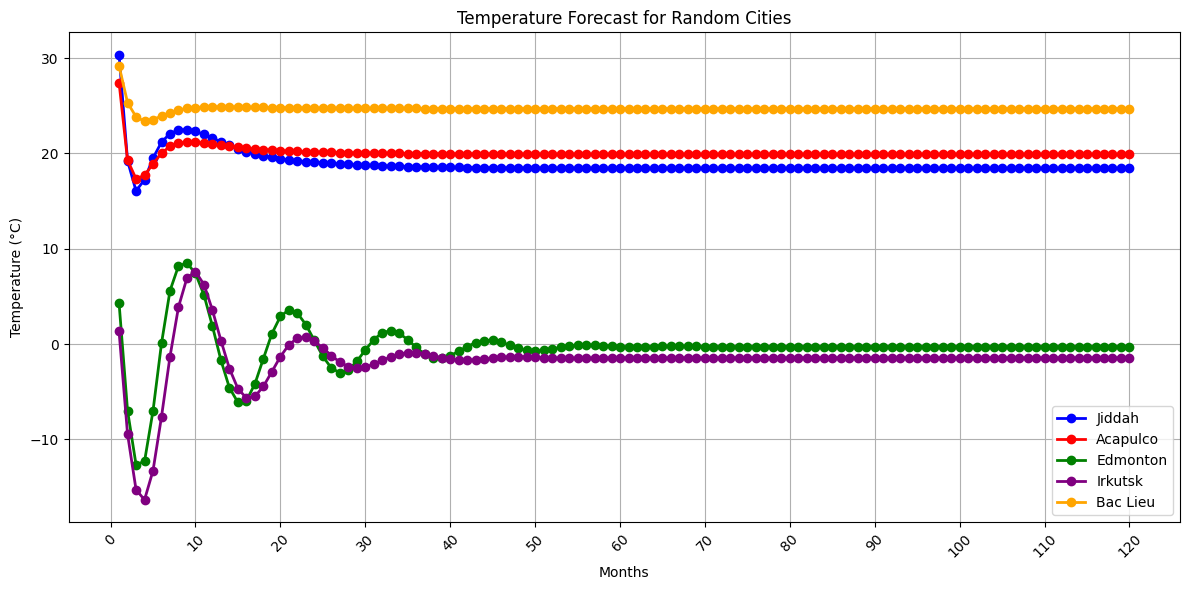

In [ ]:
months_120 = range(1, 121)
plt.figure(figsize=(12, 6))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, city in enumerate(cities):
    plt.plot(months_120, forecasts[city], marker='o', linestyle='-', color=colors[i], linewidth=2, label=f'{city}')

plt.title('Temperature Forecast for Random Cities')
plt.xlabel('Months')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(range(0, 121, 10), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
cities = ['Jiddah', 'Acapulco', 'Edmonton', 'Irkutsk', 'Bac Lieu']
colors = ['blue', 'red', 'green', 'purple', 'orange']
months_12 = range(1, 13)

plt.figure(figsize=(12, 6))
for i, city in enumerate(cities):
    plt.plot(months_12, forecasts[city][:12], marker='o', linestyle='-', color=colors[i], linewidth=2, label=f'{city}')

plt.title('Temperature Forecast for Random Cities Trained on Temperature Data')
plt.xlabel('Months')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(months_12, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()